In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from LERGfunc import *
%matplotlib inline
from astropy.table import Table
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
plt.rcParams['font.family'] = "Serif"
plt.style.use('ggplot')

In [2]:
#plt.style.use('ggplot')
#sns.set()
def plot(wo_wave,data,error,z,popt_full_fit,parameters_err,plateid,mjd,fiberid,destination_path_cube="raw/spectro/1d_26"):
    (amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4900) & (wo_wave<5050)
    select2 = (wo_wave>4990) & (wo_wave<5020)
    fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    #fig = plt.gcf()
    #fig.set_size_inches(9, 6)
    #plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    #plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    #plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    #plt.legend(fontsize=15)
    #fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    #plt.show()
    
    vel_sigma_OIII_1 = np.abs(vel_sigma_OIII_fit)
    vel_sigma_OIII_2 = np.abs(vel_sigma_OIII_br_fit)
    if vel_sigma_OIII_1 < vel_sigma_OIII_2:
        core = O3_gauss(wo_wave[select2],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit)
        wing = O3_gauss(wo_wave[select2],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit)
    else:
        wing = O3_gauss(wo_wave[select2],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit)
        core = O3_gauss(wo_wave[select2],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit)
    
    err_core = error[select2]
    max_location_core = np.where(core == np.amax(core))[0][0]
    AN_core = (core[max_location_core]/err_core[max_location_core])
    
    err_wing = error[select2]
    max_location_wing = np.where(wing == np.amax(wing))[0][0]
    AN_wing = (wing[max_location_wing]/err_wing[max_location_wing])
    
    if AN_core > 3 and AN_wing > 3 and vel_sigma_OIII_br_fit < 1000:
        print ('%s,%s,%s'%(plateid,mjd,fiberid))
#        print ('%s,%s,%s,%s'%(data['Plate'][i],data['MJD_1'][i],data['Fiber'][i],SN[i]))
        par = [plateid,mjd,fiberid]
        column_names={'PLATEID':0,'MJD':1,'FIBERID':2}
        columns=[]
        for key in column_names.keys():
            columns.append(fits.Column(name=key,format='E',array=[par[column_names[key]]]))
            coldefs = fits.ColDefs(columns)
            hdu = fits.BinTableHDU.from_columns(coldefs)
            hdu.writeto('LERG Small/%s_%s_%s_LERG.fits'%(plateid,mjd,fiberid),overwrite=True)
         #fig = plt.gcf()
        #fig.set_size_inches(9, 6)
        #plt.plot(wo_wave[select],data[select],'r-')
        #plt.fill_between(wo_wave[select], data[select]-error[select], data[select]+error[select],color='gray')
        #plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
        #plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
        #fig.savefig('LERG Plots/Spec/spSpec-%s-%s-%s_full_fit_spec.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)
        #plt.show()
        
        #fig = plt.gcf()
        #fig.set_size_inches(9, 6)
        #plt.plot(wo_wave[select],data[select],label='data',drawstyle='steps-mid',linewidth=3,color='lightgray')
        #plt.fill_between(wo_wave[select], data[select]-error[select], data[select]+error[select],color='darkgray')
        #plt.plot(wo_wave[select],fit,'r--',label='fit')
        #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
        #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
        #plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
        #plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
        #plt.legend(fontsize=15)
        #plt.show()     
        #fig.savefig('LERG Plots/Fit and Spec/spSpec-%s-%s-%s_full_fit_spec.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)
        
        #fig = plt.gcf()
        #fig.set_size_inches(9, 6)
        #plt.plot(wo_wave[select],data[select],label='data',drawstyle='steps-mid',linewidth=3,color='lightgray')
        #plt.fill_between(wo_wave[select], data[select]-error[select], data[select]+error[select],color='darkgray')
        #plt.plot(wo_wave[select],fit,'r-',label='fit')
        #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
        #plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
        #plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
        #plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
        #plt.legend(fontsize=15)
        #plt.show()     
        #fig.savefig('LERG Plots/Fit Breakdown/spSpec-%s-%s-%s_full_fit_comp.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)

        #fig = plt.gcf()
        #fig.set_size_inches(9, 3)
        #plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
        #plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
        #plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
        #plt.ylabel(r"Residual/Error",fontsize=15)
        #plt.legend(fontsize=15)
        #plt.show()     
        #fig.savefig('LERG Plots/Residual/spSpec-%s-%s-%s_residual_fit.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)

    else:
        pass
    

In [3]:
def popt_central_fit(wo_wave,data,error,z):
    k = 1+z
    v_core = 0.0
    v_wing = 100.0
    sigma_core = 10.0
    sigma_wing = 100.0
    select = (wo_wave>4900) & (wo_wave<5100)
    popt_full_fit,pcov_full_fit = leastsq(full_gauss_O3,x0=[3,v_core,sigma_core,0.5,v_wing,sigma_wing,-0.001,0.1],args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 0
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss_O3,x0=[3,v_core,sigma_core,0.5,v_wing,sigma_wing,-0.001,0.1],args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def central_table(obj,popt_full_fit,parameters_err,destination_path_cube="raw/spectro/1d_26"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    #print central_coordinates
    popt = popt_full_fit
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)



In [5]:
#plt.style.use('default')
#sns.set()
def plot_short(wo_wave,data,error,z,popt_full_fit,parameters_err,destination_path_cube="raw/spectro/1d_26"):
    (amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    k_new=(vel_OIII_fit/300000) + 1
    select = (wo_wave>4900) & (wo_wave<5050)
    select2 = (wo_wave>4990) & (wo_wave<5020)
    fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
           
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.3, 0.84, 0.66]) # main axes
    ax2 = fig.add_axes([0.1, 0.1,0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)

   
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
    ax1.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
    ax1.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
    ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
    ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
    #plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    ax1.legend(facecolor='white',framealpha=1,fontsize=21, loc='upper left', borderpad=2)
    ax1.set_xlim(4900,5045)
    ax1.axvspan(5001,5007,color='brown',alpha=0.2)
    
    ax1.annotate(r'Visible blue-wing',xy=(5000,16),xytext=(4950,30),fontsize=20)
    ax1.annotate(r'(Sign of ionized outflow)',xy=(4995,12),xytext=(4950,28),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=0.3'),fontsize=20)
    ax1.annotate(r'$v_{out}$ = - 320 km/s',xy=(5013,18),xytext=(5015,27),fontsize=18)
    ax1.annotate(r'FWHM = 750 km/s',xy=(5013,10),xytext=(5015,22),arrowprops=dict(arrowstyle='->',color='black',lw=0.8,connectionstyle='arc3,rad=-0.3'),fontsize=18)
    #ax1.axvline(x=5007, color='k', linestyle='--')   
    #ax1.axvline(x=5001, color='k', linestyle='--')   


    #fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    ax2.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='k', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.5, color='gray')
    ax2.set_ylim(-8,8)
    ax2.set_xlim(4900,5045)
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
   
    #plt.tight_layout(pad=0.001, h_pad=0.006, w_pad=0.002)
    fig.savefig('LERG Plots/Central_spectrum_full.png',overwrite=True)


    plt.show()
    

[  27.41912495  201.07164428  119.41947078   10.47920826 -117.2649407
  322.07541879   -5.33071292   26.39963107] [ nan  nan  nan  nan  nan  nan  nan  nan]


/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


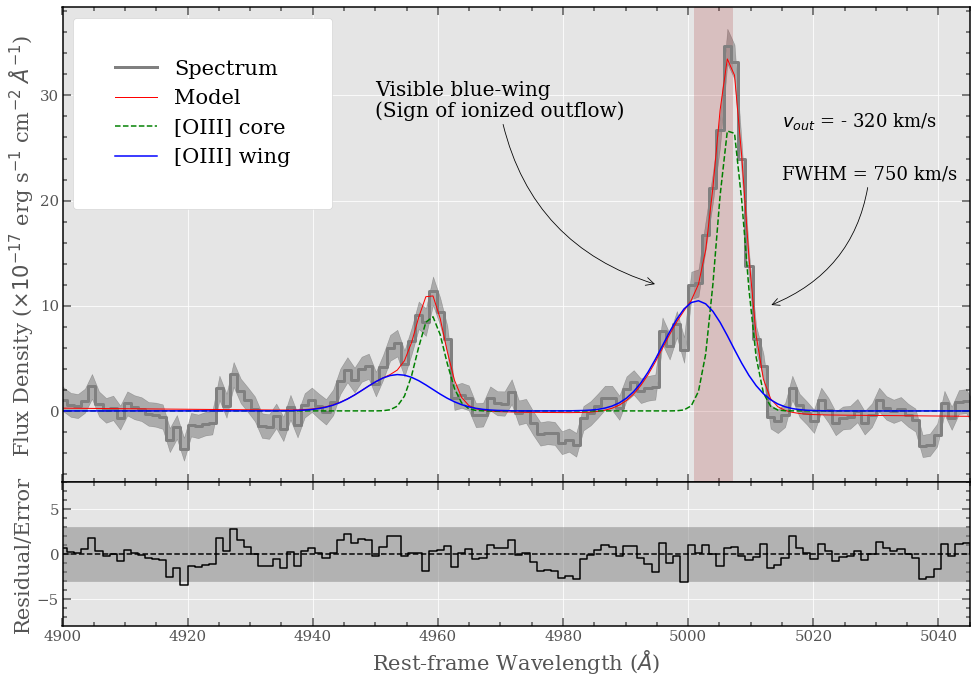

In [6]:
hdu = fits.open('raw/spectro/1d_26/0534/1d/spSpec-51997-0534-235.fit')
#hdu = fits.open('raw/spectro/1d_26/2117/1d/spSpec-54115-2117-264.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)
print (popt_full_fit,parameters_err)
plot_short(wo_wave,data,error,z,popt_full_fit,parameters_err)



/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


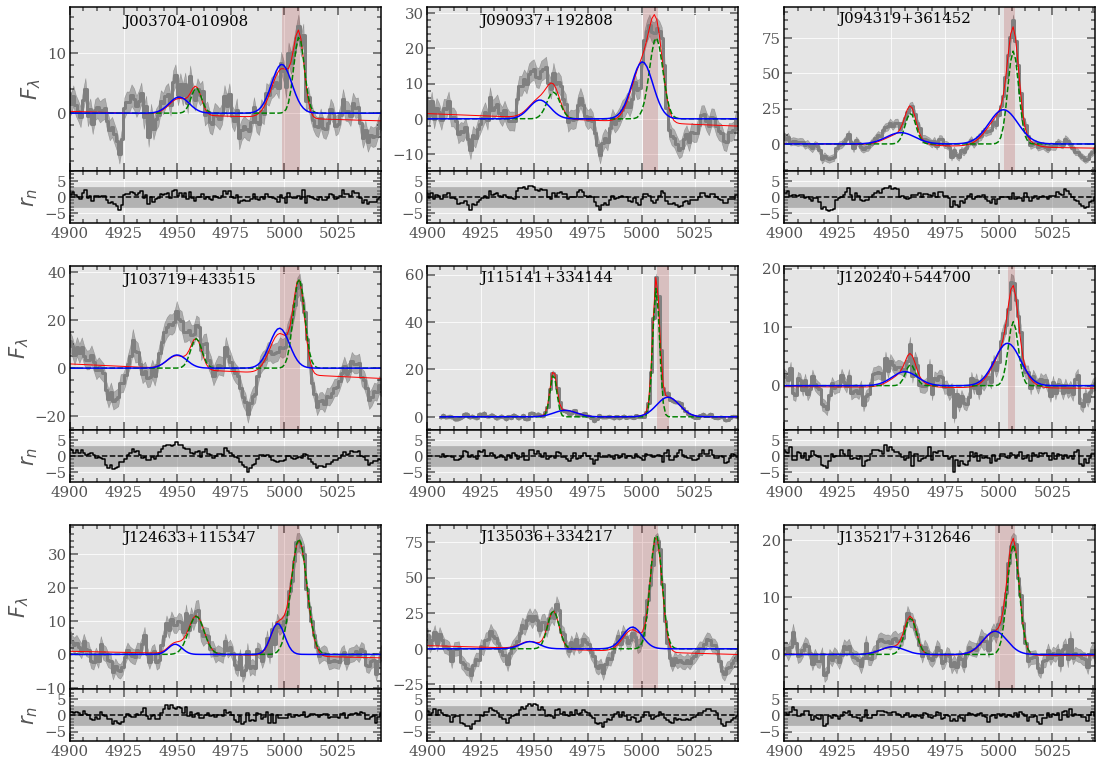

In [7]:
c = 300000
fig = plt.figure(figsize=(16, 12)) 
    
ax1 = fig.add_axes([0.1,0.69,0.27,0.19])
ax2 = fig.add_axes([0.1,0.63,0.27,0.06])

ax3 = fig.add_axes([0.41,0.69,0.27,0.19])
ax4 = fig.add_axes([0.41,0.63,0.27,0.06])

ax5 = fig.add_axes([0.72,0.69,0.27,0.19])
ax6 = fig.add_axes([0.72,0.63,0.27,0.06])

ax7 = fig.add_axes([0.1,0.39,0.27,0.19])
ax8 = fig.add_axes([0.1,0.33,0.27,0.06])

ax9 = fig.add_axes([0.41,0.39,0.27,0.19])
ax10 = fig.add_axes([0.41,0.33,0.27,0.06])

ax11 = fig.add_axes([0.72,0.39,0.27,0.19])
ax12 = fig.add_axes([0.72,0.33,0.27,0.06])

ax13 = fig.add_axes([0.1,0.09,0.27,0.19])
ax14 = fig.add_axes([0.1,0.03,0.27,0.06])

ax15 = fig.add_axes([0.41,0.09,0.27,0.19])
ax16 = fig.add_axes([0.41,0.03,0.27,0.06])

ax17 = fig.add_axes([0.72,0.09,0.27,0.19])
ax18 = fig.add_axes([0.72,0.03,0.27,0.06])


########### 3 #######################
hdu = fits.open('raw/spectro/1d_26/0690/1d/spSpec-52261-0690-207.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax1.get_xticklabels(), visible=False)

ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax1.minorticks_on()
ax1.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax1.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax1.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ax1.set_ylabel(r"$F_{\lambda}$",fontsize=21)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax1.set_xlim(4900,5045)
ax1.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
ymax = np.max(data[select])
ax1.text(4925,ymax,r'J003704-010908',color='k',fontname="Serif",fontsize=15)
   
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax2.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax2.minorticks_on()
ax2.axhline(y=0.0, color='k', linestyle='--')   
ax2.axhspan(-3, 3, alpha=0.5, color='gray')
ax2.set_ylim(-8,8)
ax2.set_xlim(4900,5045)
#ax4.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
#ax6.set_ylabel(r"Residual/Error",fontsize=21)
ax2.set_ylabel(r"$r_{n}$",fontsize=21)

############# 14
hdu = fits.open('raw/spectro/1d_26/2285/1d/spSpec-53700-2285-633.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax3.get_xticklabels(), visible=False)

ax3.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax3.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax3.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax3.minorticks_on()
ax3.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax3.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax3.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax3.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax3.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax3.text(4925,ymax,r'J090937+192808',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax3.set_xlim(4900,5045)
ax3.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax4.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax4.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax4.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax4.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax4.minorticks_on()
ax4.axhline(y=0.0, color='k', linestyle='--')   
ax4.axhspan(-3, 3, alpha=0.5, color='gray')
ax4.set_ylim(-8,8)
ax4.set_xlim(4900,5045)
#ax4.set_ylabel(r"Residual/Error",fontsize=21)
#ax4.set_ylabel(r"$r_{n}$",fontsize=21)

##################### 7############################
hdu = fits.open('raw/spectro/1d_26/1594/1d/spSpec-52992-1594-566.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax5.get_xticklabels(), visible=False)

ax5.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax5.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax5.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax5.minorticks_on()
ax5.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax5.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax5.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax5.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax5.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ymax = np.max(data[select])
ax5.text(4925,ymax - 2,r'J094319+361452',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax5.set_xlim(4900,5045)
ax5.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax6.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax6.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax6.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax6.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax6.minorticks_on()
ax6.axhline(y=0.0, color='k', linestyle='--')   
ax6.axhspan(-3, 3, alpha=0.5, color='gray')
ax6.set_ylim(-8,8)
ax6.set_xlim(4900,5045)
#ax14.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)

############## 6

hdu = fits.open('raw/spectro/1d_26/1431/1d/spSpec-52992-1431-205.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax7.get_xticklabels(), visible=False)

ax7.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax7.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax7.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax7.minorticks_on()
ax7.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax7.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax7.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax7.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax7.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ax7.set_ylabel(r"$F_{\lambda}$",fontsize=21)
ymax = np.max(data[select])
ax7.text(4925,ymax,r'J103719+433515',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax7.set_xlim(4900,5045)
ax7.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax8.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax8.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax8.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax8.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax8.minorticks_on()
ax8.axhline(y=0.0, color='k', linestyle='--')   
ax8.axhspan(-3, 3, alpha=0.5, color='gray')
ax8.set_ylim(-8,8)
ax8.set_xlim(4900,5045)
#ax4.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
#ax6.set_ylabel(r"Residual/Error",fontsize=21)
ax8.set_ylabel(r"$r_{n}$",fontsize=21)

############ 10

hdu = fits.open('raw/spectro/1d_26/2097/1d/spSpec-53491-2097-592.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
c = 300000
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax9.get_xticklabels(), visible=False)

ax9.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax9.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax9.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax9.minorticks_on()
ax9.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax9.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax9.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax9.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax9.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ymax = np.max(data[select])
ax9.text(4925,ymax - 2,r'J115141+334144',color='k',fontname="Serif",fontsize=15)

ax9.set_xlim(4900,5045)
ax9.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax10.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax10.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax10.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax10.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax10.minorticks_on()
ax10.axhline(y=0.0, color='k', linestyle='--')   
ax10.axhspan(-3, 3, alpha=0.5, color='gray')
ax10.set_ylim(-8,8)
ax10.set_xlim(4900,5045)

############## 4
hdu = fits.open('raw/spectro/1d_26/1018/1d/spSpec-52672-1018-227.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax11.get_xticklabels(), visible=False)

ax11.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax11.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax11.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax11.minorticks_on()
ax11.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax11.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax11.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax11.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax11.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ymax = np.max(data[select])
ax11.text(4925,ymax,r'J120240+544700',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax11.set_xlim(4900,5045)
ax11.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax12.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax12.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax12.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax12.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax12.minorticks_on()
ax12.axhline(y=0.0, color='k', linestyle='--')   
ax12.axhspan(-3, 3, alpha=0.5, color='gray')
ax12.set_ylim(-8,8)
ax12.set_xlim(4900,5045)

############### 8
hdu = fits.open('raw/spectro/1d_26/1694/1d/spSpec-53472-1694-101.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax13.get_xticklabels(), visible=False)

ax13.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax13.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax13.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax13.minorticks_on()
ax13.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax13.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax13.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax13.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax13.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ax13.set_ylabel(r"$F_{\lambda}$",fontsize=21)
ymax = np.max(data[select])
ax13.text(4925,ymax,r'J124633+115347',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax13.set_xlim(4900,5045)
ax13.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax14.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax14.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax14.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax14.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax14.minorticks_on()
ax14.axhline(y=0.0, color='k', linestyle='--')   
ax14.axhspan(-3, 3, alpha=0.5, color='gray')
ax14.set_ylim(-8,8)
ax14.set_xlim(4900,5045)
#ax4.set_ylabel(r"Residual/Error",fontsize=21)
ax14.set_ylabel(r"$r_{n}$",fontsize=21)

################# 9
hdu = fits.open('raw/spectro/1d_26/2028/1d/spSpec-53818-2028-060.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax15.get_xticklabels(), visible=False)

ax15.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax15.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax15.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax15.minorticks_on()
ax15.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax15.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax15.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax15.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax15.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax15.text(4925,ymax,r'J135036+334217',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax15.set_xlim(4900,5045)
ax15.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax16.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax16.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax16.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax16.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax16.minorticks_on()
ax16.axhline(y=0.0, color='k', linestyle='--')   
ax16.axhspan(-3, 3, alpha=0.5, color='gray')
ax16.set_ylim(-8,8)
ax16.set_xlim(4900,5045)
#ax6.set_ylabel(r"Residual/Error",fontsize=21)
#ax6.set_ylabel(r"$r_{n}$",fontsize=21)
fig.savefig('LERG Plots/Central_spectrum_first9.png',overwrite=True)

############# 11
hdu = fits.open('raw/spectro/1d_26/2117/1d/spSpec-54115-2117-264.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax17.get_xticklabels(), visible=False)

ax17.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax17.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax17.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax17.minorticks_on()
ax17.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax17.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax17.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax17.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax17.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax17.text(4925,ymax,r'J135217+312646',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax17.set_xlim(4900,5045)
ax17.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax18.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax18.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax18.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax18.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax18.minorticks_on()
ax18.axhline(y=0.0, color='k', linestyle='--')   
ax18.axhspan(-3, 3, alpha=0.5, color='gray')
ax18.set_ylim(-8,8)
ax18.set_xlim(4900,5045)
#ax4.set_ylabel(r"Residual/Error",fontsize=21)
#ax4.set_ylabel(r"$r_{n}$",fontsize=21)
fig.savefig('LERG Plots/Central_spectrum_first9.png',overwrite=True)


/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


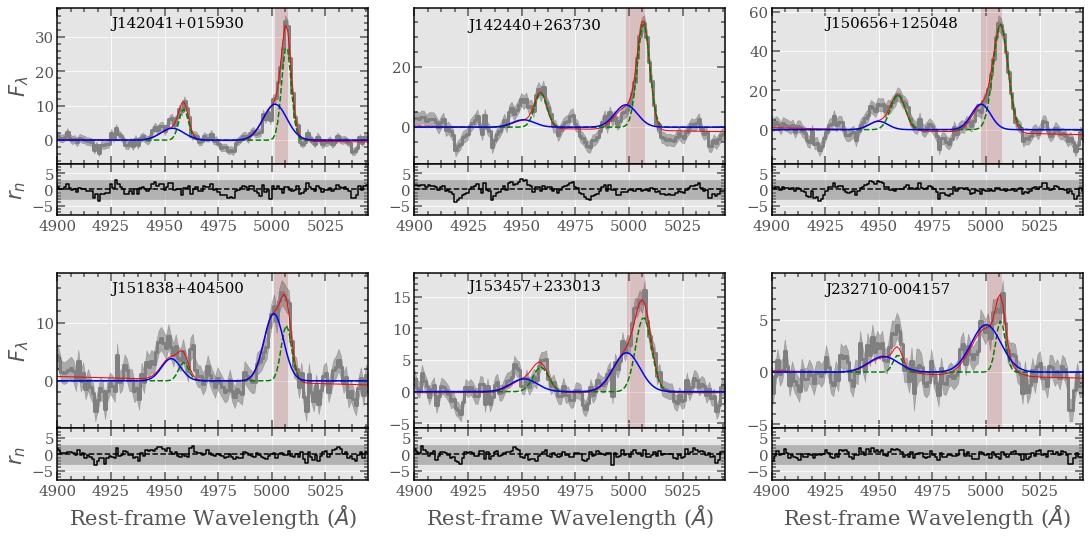

In [8]:
fig = plt.figure(figsize=(16, 8)) 

ax1 = fig.add_axes([0.1,0.67,0.27,0.27])
ax2 = fig.add_axes([0.1,0.58,0.27,0.09])

ax3 = fig.add_axes([0.41,0.67,0.27,0.27])
ax4 = fig.add_axes([0.41,0.58,0.27,0.09])

ax5 = fig.add_axes([0.72,0.67,0.27,0.27])
ax6 = fig.add_axes([0.72,0.58,0.27,0.09])

ax7 = fig.add_axes([0.1,0.21,0.27,0.27])
ax8 = fig.add_axes([0.1,0.12,0.27,0.09])

ax9 = fig.add_axes([0.41,0.21,0.27,0.27])
ax10 = fig.add_axes([0.41,0.12,0.27,0.09])

ax11 = fig.add_axes([0.72,0.21,0.27,0.27])
ax12 = fig.add_axes([0.72,0.12,0.27,0.09])

##############1#####
hdu = fits.open('raw/spectro/1d_26/0534/1d/spSpec-51997-0534-235.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
c = 300000
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax1.get_xticklabels(), visible=False)

ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax1.minorticks_on()
ax1.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax1.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax1.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax1.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ax1.set_ylabel(r"$F_{\lambda}$",fontsize=21)
ymax = np.max(data[select])
ax1.text(4925,ymax - 2,r'J142041+015930',color='k',fontname="Serif",fontsize=15)

ax1.set_xlim(4900,5045)
ax1.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax2.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax2.minorticks_on()
ax2.axhline(y=0.0, color='k', linestyle='--')   
ax2.axhspan(-3, 3, alpha=0.5, color='gray')
ax2.set_ylim(-8,8)
ax2.set_xlim(4900,5045)
#ax2.set_ylabel(r"Residual/Error",fontsize=21)
ax2.set_ylabel(r"$r_{n}$",fontsize=21)

############## 12

hdu = fits.open('raw/spectro/1d_26/2131/1d/spSpec-53819-2131-533.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax3.get_xticklabels(), visible=False)

ax3.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax3.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax3.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax3.minorticks_on()
ax3.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax3.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax3.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax3.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax3.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax3.text(4925,ymax - 2,r'J142440+263730',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax3.set_xlim(4900,5045)
ax3.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax4.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax4.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax4.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax4.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax4.minorticks_on()
ax4.axhline(y=0.0, color='k', linestyle='--')   
ax4.axhspan(-3, 3, alpha=0.5, color='gray')
ax4.set_ylim(-8,8)
ax4.set_xlim(4900,5045)
#ax4.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
#ax6.set_ylabel(r"Residual/Error",fontsize=21)
#ax6.set_ylabel(r"$r_{n}$",fontsize=21)

################# 15

hdu = fits.open('raw/spectro/1d_26/2751/1d/spSpec-54243-2751-012.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax5.get_xticklabels(), visible=False)

ax5.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax5.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax5.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax5.minorticks_on()
ax5.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax5.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax5.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax5.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax5.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax5.text(4925,ymax - 2,r'J150656+125048',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax5.set_xlim(4900,5045)
ax5.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax6.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax6.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax6.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax6.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax6.minorticks_on()
ax6.axhline(y=0.0, color='k', linestyle='--')   
ax6.axhspan(-3, 3, alpha=0.5, color='gray')
ax6.set_ylim(-8,8)
ax6.set_xlim(4900,5045)
#ax6.set_ylabel(r"Residual/Error",fontsize=21)
#ax6.set_ylabel(r"$r_{n}$",fontsize=21)
fig.savefig('LERG Plots/Central_spectrum_last6.png',overwrite=True)

############### 5
hdu = fits.open('raw/spectro/1d_26/1292/1d/spSpec-52736-1292-507.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax7.get_xticklabels(), visible=False)

ax7.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax7.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax7.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax7.minorticks_on()
ax7.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax7.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax7.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax7.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax7.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ax7.set_ylabel(r"$F_{\lambda}$",fontsize=21)
ymax = np.max(data[select])
ax7.text(4925,ymax,r'J151838+404500',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax7.set_xlim(4900,5045)
ax7.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax8.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax8.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax8.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax8.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax8.minorticks_on()
ax8.axhline(y=0.0, color='k', linestyle='--')   
ax8.axhspan(-3, 3, alpha=0.5, color='gray')
ax8.set_ylim(-8,8)
ax8.set_xlim(4900,5045)
ax8.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
#ax4.set_ylabel(r"Residual/Error",fontsize=21)
ax8.set_ylabel(r"$r_{n}$",fontsize=21)

########### 13

hdu = fits.open('raw/spectro/1d_26/2163/1d/spSpec-53823-2163-058.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax9.get_xticklabels(), visible=False)

ax9.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax9.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax9.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax9.minorticks_on()
ax9.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax9.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax9.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax9.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax9.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
ymax = np.max(data[select])
ax9.text(4925,ymax,r'J153457+233013',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax9.set_xlim(4900,5045)
ax9.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax10.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax10.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax10.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax10.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax10.minorticks_on()
ax10.axhline(y=0.0, color='k', linestyle='--')   
ax10.axhspan(-3, 3, alpha=0.5, color='gray')
ax10.set_ylim(-8,8)
ax10.set_xlim(4900,5045)
ax10.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)

##########2

hdu = fits.open('raw/spectro/1d_26/0680/1d/spSpec-52200-0680-030.fit')
dat = hdu[0].data
header = hdu[0].header
hdu.close()

z = header['z']
k=1+z
data = dat[1]
error = dat[2]
wavestart = header['COEFF0']
waveint = header['COEFF1'] 
wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
SN_OIII5007 = np.median(data[select_OIII5007]/error[select_OIII5007])
(popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)

(amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
k = 1+z
k_new=(vel_OIII_fit/300000) + 1
select = (wo_wave>4900) & (wo_wave<5050)
select2 = (wo_wave>4990) & (wo_wave<5020)
fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
residual = data[select] - fit
           
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'k'
#fig = plt.figure(figsize=(15, 10)) 
#gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1])
plt.setp(ax11.get_xticklabels(), visible=False)

ax11.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax11.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax11.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax11.minorticks_on()
ax11.plot(wo_wave[select]/k_new,data[select],color='gray',label='Spectrum',drawstyle='steps-mid',lw = 3)
ax11.fill_between(wo_wave[select]/k_new,y1=data[select]-error[select],y2=data[select]+error[select],color='k',alpha=0.25)
ax11.plot(wo_wave[select]/k_new,fit,color='r',label='Model',lw = 1)
ax11.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label=r'[OIII] core')
ax11.plot(wo_wave[select]/k_new,O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='[OIII] wing')
#plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
#ax1.set_ylabel(r"Flux Density ($\times 10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
#ax3.set_ylabel(r"$F_{\lambda}$) ",fontsize=21)
ymax = np.max(data[select])
ax11.text(4925,ymax,r'J232710-004157',color='k',fontname="Serif",fontsize=15)

#ax1.legend(facecolor='white', framealpha=1, fontsize=21, loc='upper left')
ax11.set_xlim(4900,5045)
ax11.axvspan(((vel_OIII_br_fit - vel_OIII_fit)/c)*5007 + 5007,5007,color='brown',alpha=0.2)
    
#fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
ax12.plot(wo_wave[select]/k_new,residual/error[select],drawstyle='steps-mid',color='black')
ax12.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
ax12.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
ax12.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
ax12.minorticks_on()
ax12.axhline(y=0.0, color='k', linestyle='--')   
ax12.axhspan(-3, 3, alpha=0.5, color='gray')
ax12.set_ylim(-8,8)
ax12.set_xlim(4900,5045)
ax12.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
#ax4.set_ylabel(r"Residual/Error",fontsize=21)
#ax4.set_ylabel(r"$r_{n}$",fontsize=21)
fig.savefig('LERG Plots/Central_spectrum_last6.png',overwrite=True)


